In [13]:
import pandas as pd
import numpy as np
import io
import xgboost as xgb
import os
os.environ["PATH"] += os.pathsep + r"C:\Program Files\Graphviz\bin"

In [3]:
from sklearn.model_selection import train_test_split

df = pd.read_csv(r"C:\Users\user\Desktop\repos\igem-model\data\final.csv")
df = df.drop(df[df["population"].isna()].index)
X = df.drop(columns=["infection"])
X["density"] = X["population"]/X["area"]
y = df["infection"].astype("float64")
display(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, )


0         1.0
1         1.0
2         0.0
3         0.0
4         0.0
         ... 
10089     0.0
10090     4.0
10091     4.0
10092    33.0
10093    45.0
Name: infection, Length: 9878, dtype: float64

In [4]:
X.describe()

,year,month,forest cover,population,area,oro_temp,juntamoji_temp,debesuotumas,slegis_juros_lyg,santyk_oro_dregme,kritutliu_kiekis,density
count,9878.000000,9878.000000,9878.000000,9878.000000,9878.000000,9873.000000,3270.000000,3250.000000,3270.000000,3270.000000,9878.000000,9878.000000
mean,2010.596578,6.537862,32.660215,97552.837821,2034.189006,7.481953,7.205333,58.527727,1015.462579,79.014977,59.067868,201.067636
std,4.080929,3.436450,12.775788,149172.223939,2186.840810,8.064877,8.735728,19.402729,3.650333,7.760224,36.071205,501.616665
min,2004.000000,1.000000,0.600000,2564.000000,39.000000,-12.038710,-12.197043,0.000000,1006.318548,58.009409,2.000000,10.054152
25%,2007.000000,4.000000,26.000000,27689.000000,1033.000000,0.996774,0.448452,47.913674,1012.427361,73.330645,34.200000,21.441567
50%,2011.000000,7.000000,32.300000,40270.000000,1395.000000,7.406452,7.437231,58.105263,1015.476210,78.575000,52.100000,30.167561
75%,2014.000000,10.000000,36.600000,93422.000000,1764.000000,14.580000,15.013472,74.896978,1017.794758,85.468750,76.000000,44.746295
max,2018.000000,12.000000,83.000000,841748.000000,9730.000000,22.158065,21.703898,94.550000,1024.725556,95.904441,286.000000,2318.165605


In [ ]:
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBRegressor

estimators = [
    #('encoder', TargetEncoder()),
    ('clf', XGBRegressor())
]
pipe = Pipeline(steps=estimators)

from sklearn.model_selection import BaseCrossValidator

class SpatialCV(BaseCrossValidator):
    """
    Custom cross-validator that:
      - Splits municipalities (no leakage between train/val)
      - Only uses years < 2017 for CV
    """
    def __init__(self, names, years, n_splits=5, random_state=42):
        self.names = np.array(names)
        self.years = np.array(years)
        self.n_splits = n_splits
        self.random_state = random_state

    def split(self, X, y=None, groups=None):
        pre_mask = self.years < 2017
        idx_pre = np.where(pre_mask)[0]

        munis = np.unique(self.names[idx_pre])
        rng = np.random.RandomState(self.random_state)
        rng.shuffle(munis)

        fold_sizes = np.full(self.n_splits, len(munis) // self.n_splits, dtype=int)
        fold_sizes[:len(munis) % self.n_splits] += 1

        current = 0
        for fold_size in fold_sizes:
            val_munis = munis[current:current + fold_size]
            current += fold_size

            val_idx = idx_pre[np.isin(self.names[idx_pre], val_munis)]
            train_idx = idx_pre[~np.isin(self.names[idx_pre], val_munis)]

            yield train_idx, val_idx

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits



In [6]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

search_space = {
    'clf__max_depth': Integer(3,8),
    'clf__learning_rate': Real(0.01, 0.1, prior='log-uniform'),
    'clf__subsample': Real(0.5, 1.0),
    'clf__colsample_bytree': Real(0.5, 1.0),
    'clf__colsample_bylevel': Real(0.5, 1.0),
    'clf__colsample_bynode' : Real(0.5, 1.0),
    'clf__reg_alpha': Real(0.0, 10.0),
    'clf__reg_lambda': Real(0.0, 10.0),
    'clf__gamma': Real(0.0, 10.0),
    'clf__n_estimators': Integer(500, 1000)
}
score = "neg_mean_squared_error"
#score = "r2"
cv = SpatialCV(
    names=df["name"].values,
    years=df["year"].values,
    n_splits=5,
    random_state=42
)
opt = BayesSearchCV(pipe, search_space, cv=cv, n_iter=10, scoring="neg_mean_absolute_error",n_jobs=-1 ) 
X = df.drop(columns=["infection", "name"])
y = df["infection"]

X_train = df[df["year"] < 2017].drop(columns=["infection", "name"])
y_train = df[df["year"] < 2017]["infection"]

X_test = df[df["year"] >= 2017].drop(columns=["infection", "name"])
y_test = df[df["year"] >= 2017]["infection"]

opt.fit(X_train,y_train)

,estimator,"Pipeline(step...=None, ...))])"
,search_spaces,"{'clf__colsample_bylevel': Real(low=0.5,...m='normalize'), 'clf__colsample_bynode': Real(low=0.5,...m='normalize'), 'clf__colsample_bytree': Real(low=0.5,...m='normalize'), 'clf__gamma': Real(low=0.0,...m='normalize'), ...}"
,optimizer_kwargs,None
,n_iter,10
,scoring,'neg_mean_absolute_error'
,fit_params,None
,n_jobs,-1
,n_points,1
,iid,'deprecated'
,refit,True
,cv,SpatialCV(n_s... dtype=int64))


In [7]:
best_model = opt.best_estimator_

y_train_log = np.log1p(y_train)
y_test_log  = np.log1p(y_test)

best_model.fit(X_train, y_train_log)
y_pred_log = best_model.predict(X_test)
y_pred = np.expm1(y_pred_log)

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

mae_test = mean_absolute_error(y_test, y_pred)
rmse_test = mean_squared_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

print("Temporal Test MAE:", mae_test)
print("Temporal Test RMSE:", (rmse_test)**0.5)
print("Temporal Test R²:", r2_test)


Temporal Test MAE: 3.191486120223999
Temporal Test RMSE: 8.306712954143718
Temporal Test R²: 0.8038429021835327


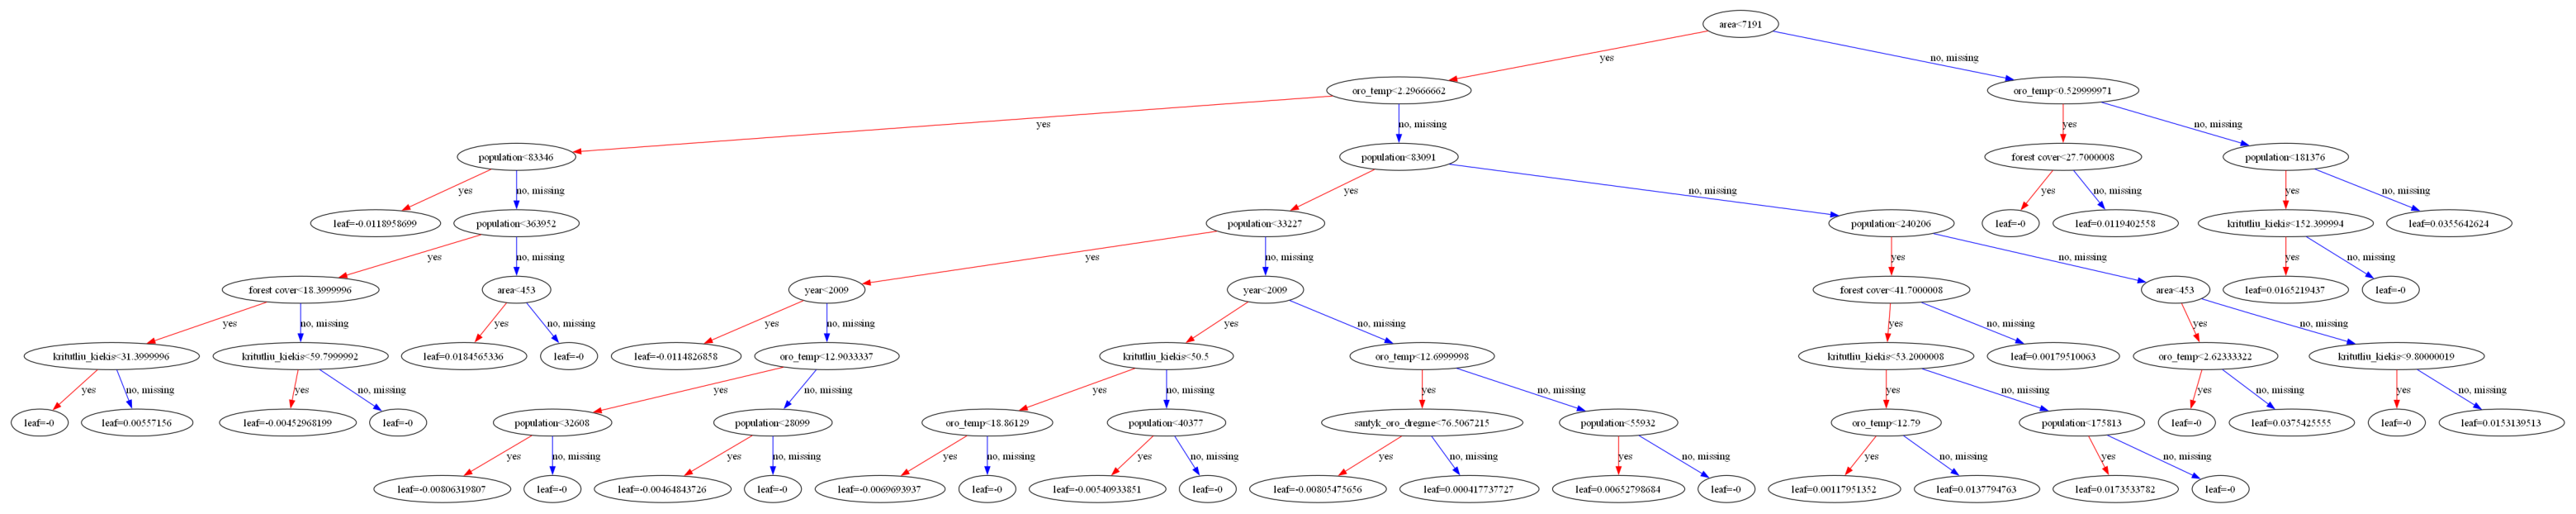

In [18]:
from xgboost import plot_tree, plot_importance
import matplotlib.pyplot as plt

# Plot a single tree
fig, ax = plt.subplots(figsize=(40, 40))
plot_tree(best_model.named_steps["clf"], num_trees=0, rankdir="UD",ax=ax)
plt.savefig("tree0.png", dpi=300, bbox_inches="tight")
plt.show()

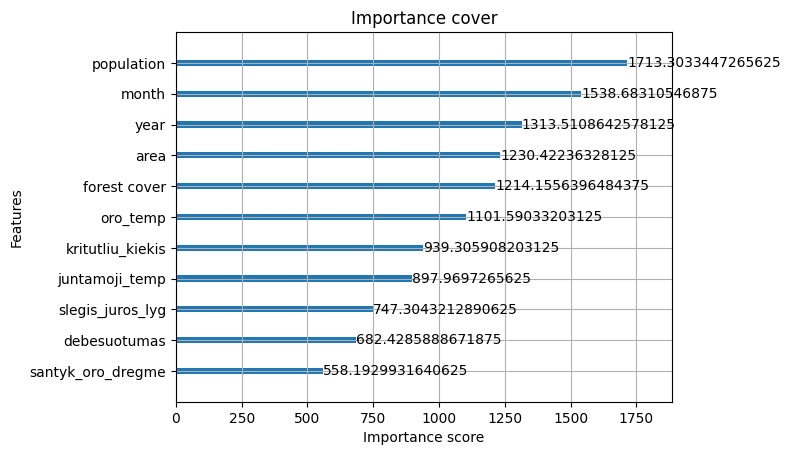

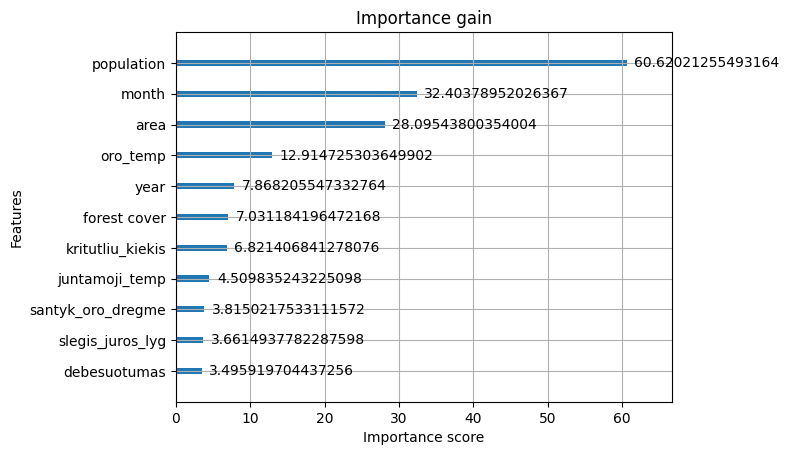

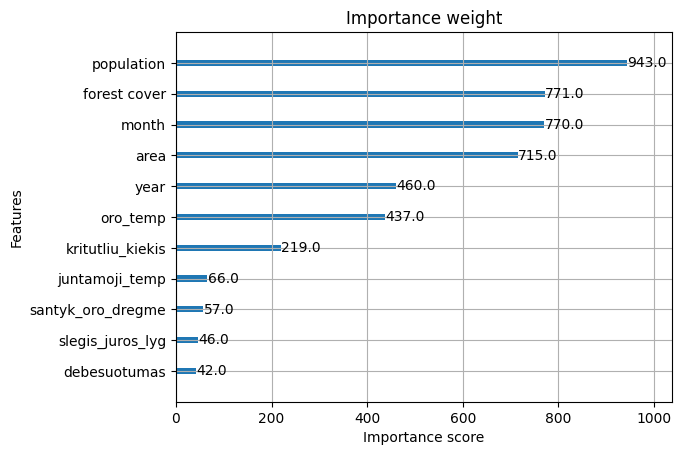

In [32]:
import matplotlib.pyplot as plt

for way in ["cover", "gain", "weight"]: 
    xgb.plot_importance(best_model.named_steps["clf"], importance_type=way, height=0.2)
    plt.title(f'Importance {way}')
    plt.show()

 96%|=================== | 1169/1218 [00:15<00:00]       

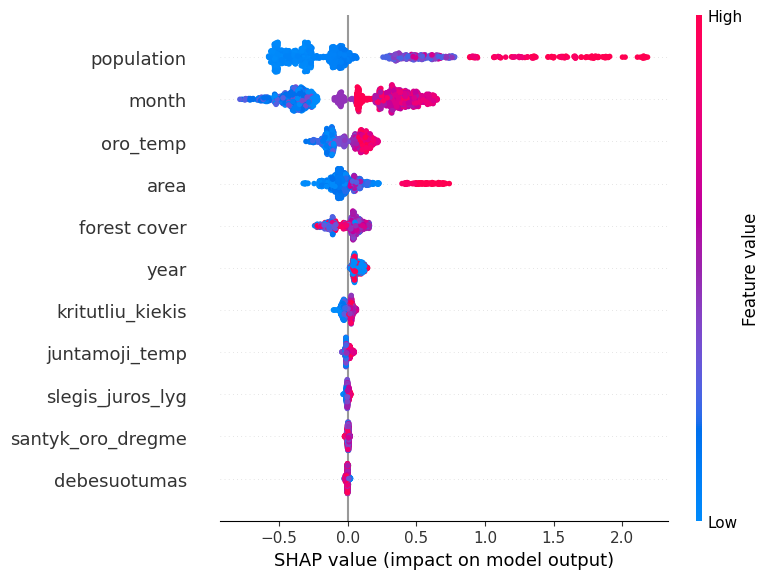

In [30]:
import shap
shap.initjs()
# Create the explainer
explainer = shap.Explainer(best_model.named_steps["clf"], X_train)

# Get SHAP values for the test set
shap_values = explainer(X_test)

# Pick one sample
i = 0
sample_shap = shap_values[i]
shap.summary_plot(shap_values, X_test)
# Force plot
shap.force_plot(explainer.expected_value, sample_shap.values, X_test.iloc[i])